<a href="https://colab.research.google.com/github/jvallalta/primeros-pasos/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN: Primeros Pasos
## Activaciones

Las activaciones son funciones que tienen como entrada un número real y generan a la salida un número real en un cierto rango, utilizando una funcion diferenciable no lineal. La diferencialidad es necesaria para backpropagation y la no linealidad para modelar funciones complejas.

Las funciones de activación más comunes son:

- ReLU
- Leaky ReLU
- Sigmoid
- Tanh

ReLU es una de las funciones más utilizadas: ReLU(X) = max(0,x). Tiene como problema el Dying ReLU problem por el que la red puede dejar de aprender que se resuelve con la funcion Leaky ReLU (usa generalmente un valor de 0.1).

La Sigmoide genera valores en 0 y 1. Se utiliza generalmente en los modelos de clasificación binario en la última capa para generar la probabildad de una clase. No se suele utilzar en  capas intermedias por los efectos del gradiente desvaneciente y los problemas de saturación.

Una función similar es la tangente hiperbólica con valores en [-1,1].  Una diferencia con la sigmoide es que mantiene el signo de la entrada. Presenta los mismos problemas que la sigmoide para las capas intermedias.






## Batch Normalization

Las GAN son muy dificiles de entrentar. Hay técnicas que mejoran tanto la velocidad como la estabilidad del entrenamiento. Una de esas técnicas es la normalización por lotes.

Si las distribuciones de las variables de entrada son muy diferentes afecta a al entremaiento, haciéndolo más lento y muy dependiente del valor inicial de los pesos.

Si las variables de entrada están normalizadas, la función de coste será mucho más equilibrada y el entrenamiento más rápido. Los datos de entrenamiento se normalizan con las estadísticas del lote (batch) y los datos de test con las estadísticas de training. Si se utiliza normalización se reduce considerablemente el desplazamiento covariable (covariate shift).

Las redes neuronales profundas pueden ser afectadas por lo que se denomina *internal covariate shift*. Para resolver este problema aplicaremos batch normalization a la entrada de cada neurona.

En  resumen, la normalización de batch suvaiza la función de coste, reduce el desplazamiento de las covariables y acelera el aprendizaje.



## Convoluciones

Las convolucionesp permiten detectar características en distinzas zonas de las imágenes utilizando filtros. Los filtros son matrices de valores reales que se aprenden durante el entrenamiento. Esos filtros se utilizan para calcular convoluciones con la imagen.

Las convoluciones son capas útiles para el procesado de imágenes. Escanean las imágenes para encontrar características releavantes y consisten en productos elemento-elemento y sumas.



## Padding y stride

Si al aplicar la convolución nos movemos 1 pixel a la derecha y 1 pixel hacia abajo el stride es 1. Cuanto mayor sea el stride se cubrirá un menor zona de la imagen por el filtro pero más rápidos serán los cálculos. 

El padding fija un marco alrededor de la imagen. 0 padding implica que cada pixel de la imagen se visita el mismo número de veces. Así se consigue dar la misma importancia al centro que a la periferia de la imagen.




## Pooling y upsampling

Se utiliza muy frecuentemente en CNN. Pooling se utiliza para reducir la imagen de salid y unsampling para aumentarla.

Una de las técnicas más utilzadas es Max Pooling que toma el máximo del subconjunto de pixeles considerados. Otrpos tpos de Pooling son Average Pooling y Min Pooling. Las capas de pooling no aprenden.

Upsampling es la operacion contraria. Aumenta el tamño de una imagen infiriendo pixeles. Hay diversos métodos: vecinos más cercanos, interpolación lineal e interpolación bilineal.

## Convolución transpuesta

Es una técnica de upsamplign que utiliza convoluciones para ampliar el tamaño de la entrada. El problema es que generan un patrón de tablero de ajedres en algunas zonas de la imagen.

## Implementación

Vamos a implementar una DCGAN según el [artículo original](https://arxiv.org/pdf/1511.06434v1.pdftps://).

Estas son las características principales de DCGAN:

- Utiliza convoluciones sin capas de agrupación
- Usa batchnorm tanto en el generador como en el discriminador
- No usa capas ocultas completamente conectadas
- Usa la activación de ReLU en el generador para todas las capas excepto para la salida, que usa una activación de Tanh.
- Usa la activación de LeakyReLU en el discriminador para todas las capas excepto para la salida, que no usa una activación

Comenzaremos importando algunos paquetes y datos útiles que nos ayudarán a crear  la GAN. También definiremos una función de visualizador para ayudar a ver las imágenes que creará la GAN.

## Imports

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generador
El primer componente es el generador. Se puede notar que en lugar de pasar la dimensión de la imagen, se pasará el número de canales de imagen al generador. Esto se debe a que con DCGAN, utiliza convoluciones que no dependen de la cantidad de píxeles de una imagen. Sin embargo, el número de canales es importante para determinar el tamaño de los filtros.

Se construirá un generador usando 4 capas (3 capas ocultas + 1 capa de salida). Definiremos una función para crear un solo bloque para la red neuronal del generador.

Al final de la clase del generador, se le da una función de paso hacia adelante que toma un vector de ruido y genera una imagen de la dimensión de salida usando su red neuronal. También se le da una función para crear un vector de ruido. 

In [2]:
# Generador
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
               
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
               
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
                
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminador
El segundo componente que se necesita crear es el discriminador.

Se utilizarán 3 capas en la red neuronal del discriminador. Al igual que con el generador, definiremos una función para crear un único bloque de red neuronal para el discriminador.

In [3]:
# Discriminador
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
               
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
               
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride)
                
                
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training
Definimos los parámetros

- criterion: the loss function
- n_epochs: the number of times you iterate through the entire dataset when training
- z_dim: the dimension of the noise vector
- display_step: how often to display/visualize the images
- batch_size: the number of images per forward/backward pass
- lr: the learning rate
- beta_1, beta_2: the momentum term
- device: the device type

In [5]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ 
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Inicializamos generador, discriminador y optimizadores.

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finalmente entrenamos la GAN. Para cada época, procesará todo el conjunto de datos en lotes. Para cada lote, actualizará el discriminador y el generador. Y mostraremos los resultados de la GAN

Esta es aproximadamente la progresión que se debería esperar. En la GPU, esto tarda unos 30 segundos por cada mil pasos. En la CPU, esto puede llevar alrededor de 8 horas por cada mil pasos. Puede notar que en la imagen del Paso 5000, el generador está produciendo desproporcionadamente cosas que se parecen a ellas. Si el discriminador no aprendió a detectar este desequilibrio lo suficientemente rápido, entonces el generador podría producir más. Como resultado, puede haber terminado engañando al discriminador tan bien que no habría más mejoras, lo que se conoce como colapso de modo: Progresión de dígitos de MNIST

Step 500: Generator loss: 0.8783292812705039, discriminator loss: 0.5408980225920681


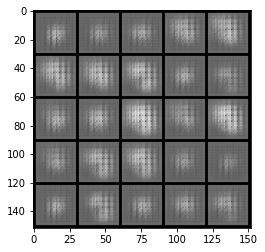

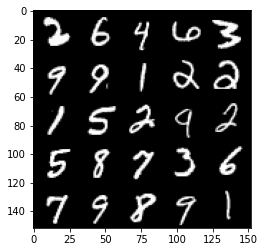

Step 1000: Generator loss: 1.7425521901845926, discriminator loss: 0.3352767147123812


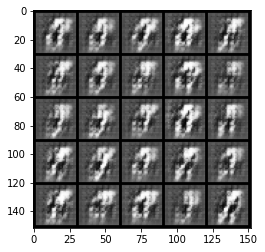

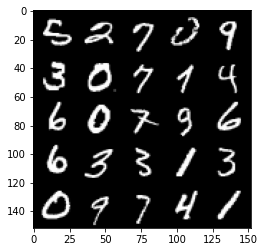

Step 1500: Generator loss: 1.1968751290440565, discriminator loss: 0.5323964197039603


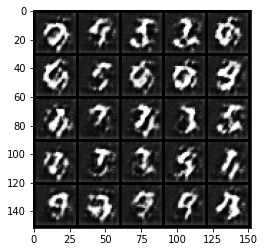

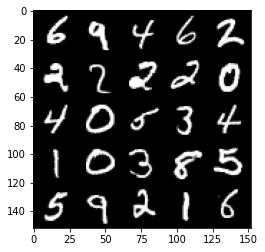

Step 2000: Generator loss: 0.985717755973339, discriminator loss: 0.5691664344668388


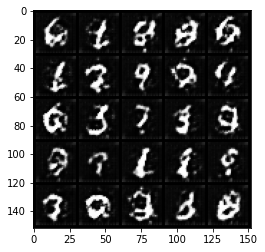

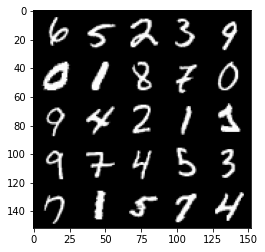

Step 2500: Generator loss: 0.8770298339128507, discriminator loss: 0.6119967907667169


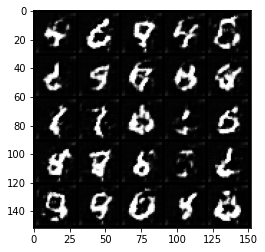

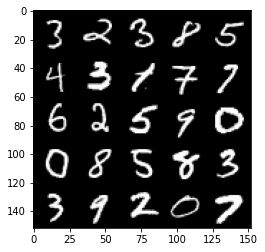

Step 3000: Generator loss: 0.8422919614911089, discriminator loss: 0.6288708915710451


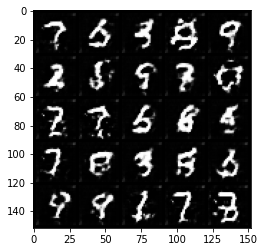

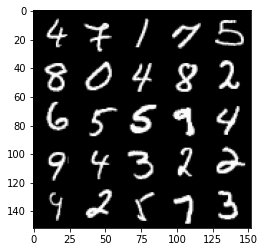

Step 3500: Generator loss: 0.8037180938124653, discriminator loss: 0.651119384288788


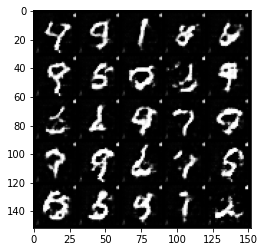

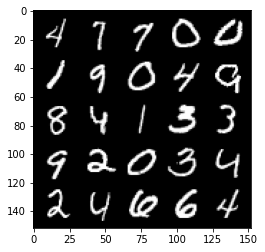

Step 4000: Generator loss: 0.7881794250011445, discriminator loss: 0.6597193492650978


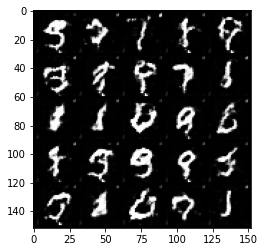

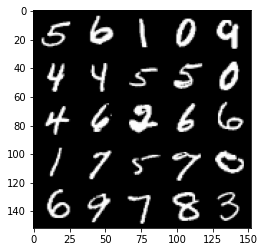

Step 4500: Generator loss: 0.7782027536630636, discriminator loss: 0.6707012522220605


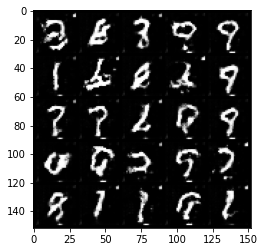

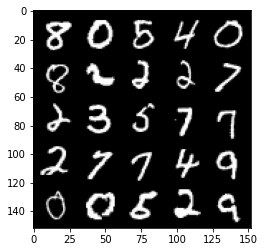

Step 5000: Generator loss: 0.771137924671174, discriminator loss: 0.6701723314523693


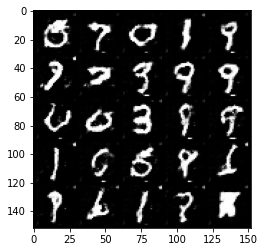

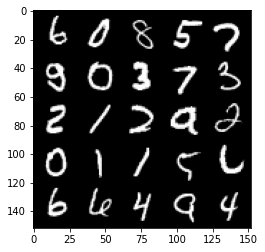

Step 5500: Generator loss: 0.7570485562086102, discriminator loss: 0.676101123452186


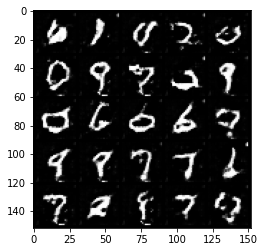

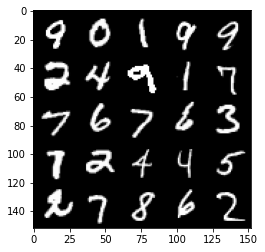

Step 6000: Generator loss: 0.7561949722170825, discriminator loss: 0.6766465836763377


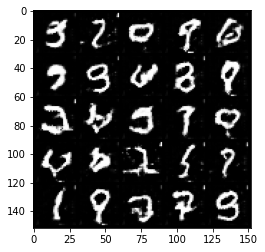

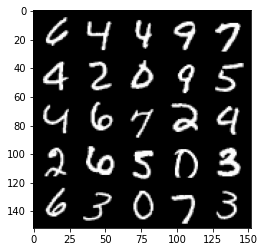

Step 6500: Generator loss: 0.7613943259716035, discriminator loss: 0.6792240157127379


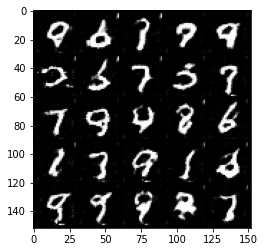

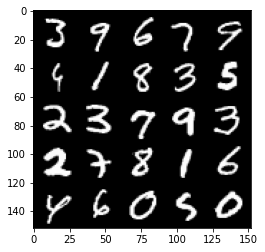

Step 7000: Generator loss: 0.7558422164916992, discriminator loss: 0.6774056169986727


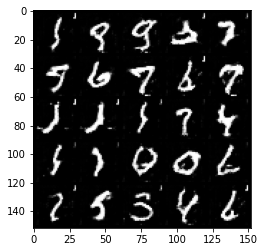

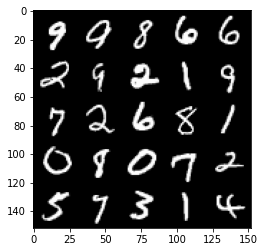

Step 7500: Generator loss: 0.7506780412793163, discriminator loss: 0.6790850423574448


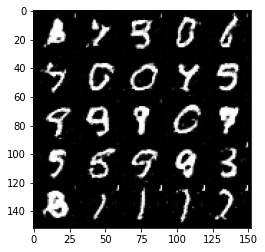

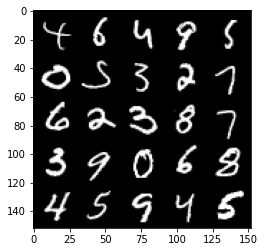

Step 8000: Generator loss: 0.7554898582100874, discriminator loss: 0.6802487493753432


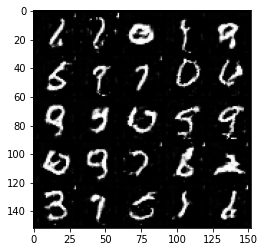

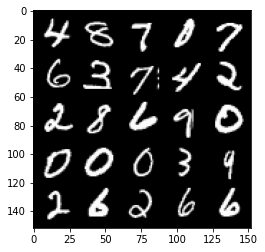

Step 8500: Generator loss: 0.7505973092913636, discriminator loss: 0.6804923194646835


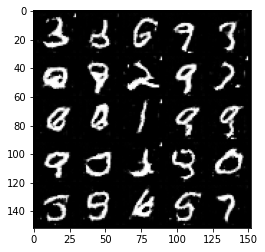

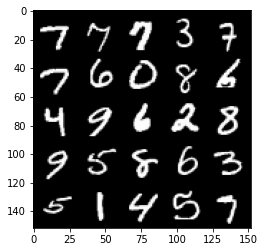

Step 9000: Generator loss: 0.7456064807772641, discriminator loss: 0.6822770136594769


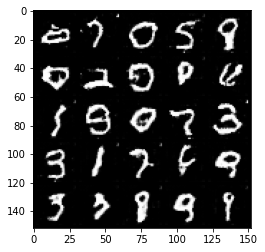

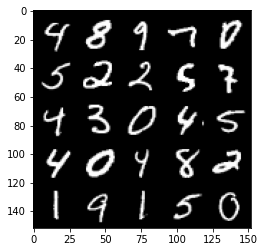

Step 9500: Generator loss: 0.7451664116978656, discriminator loss: 0.6824358085393911


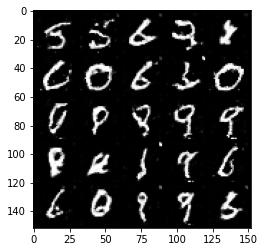

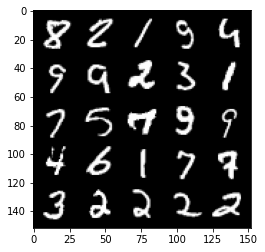

Step 10000: Generator loss: 0.7417910305857648, discriminator loss: 0.6834374428987502


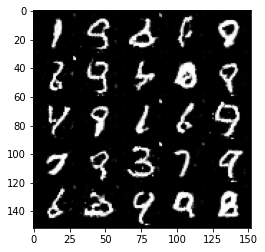

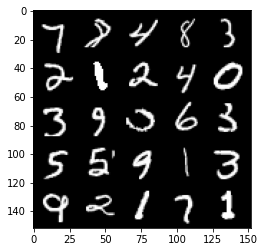

Step 10500: Generator loss: 0.7387956852316858, discriminator loss: 0.6822577567100523


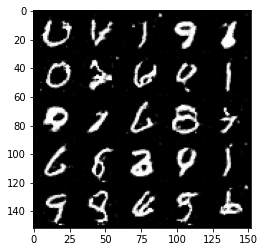

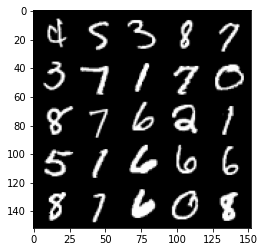

Step 11000: Generator loss: 0.7355584324002264, discriminator loss: 0.6850983343124384


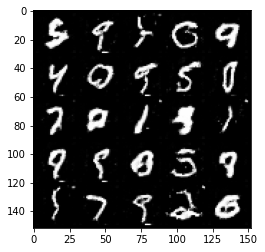

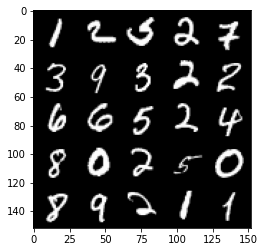

Step 11500: Generator loss: 0.7309367691278464, discriminator loss: 0.6857909104824061


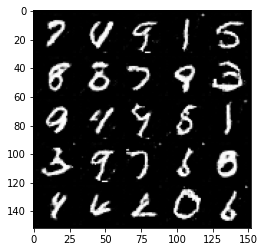

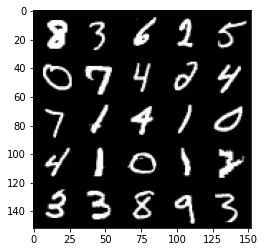

Step 12000: Generator loss: 0.7298672702908524, discriminator loss: 0.6875643004178998


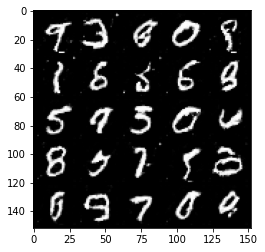

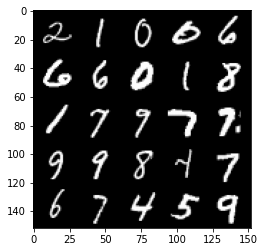

Step 12500: Generator loss: 0.7263790135979654, discriminator loss: 0.6898372669219974


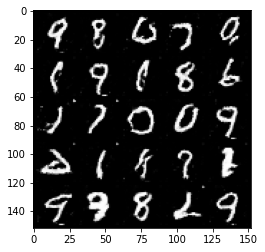

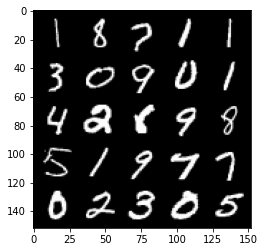

Step 13000: Generator loss: 0.7223182590603826, discriminator loss: 0.691478442549705


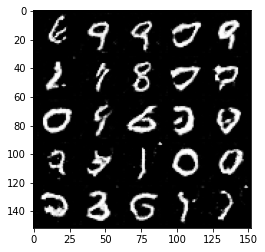

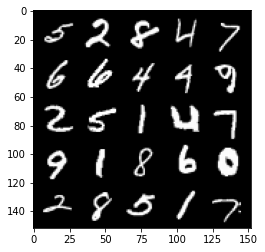

Step 13500: Generator loss: 0.7229585032463072, discriminator loss: 0.6914581507444382


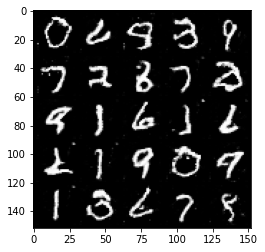

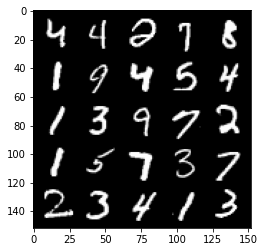

Step 14000: Generator loss: 0.7170504811406144, discriminator loss: 0.6930454269647599


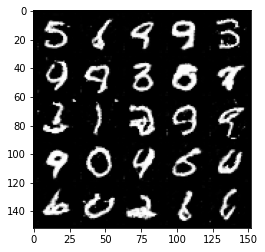

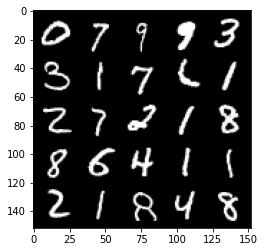

Step 14500: Generator loss: 0.714585324823857, discriminator loss: 0.6928074910640727


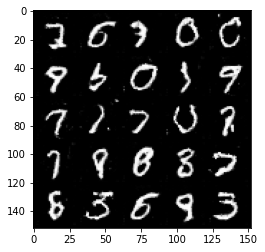

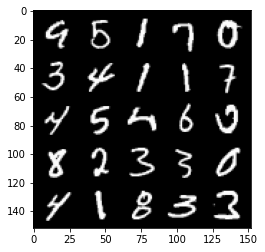

Step 15000: Generator loss: 0.714934444546699, discriminator loss: 0.6938886587619775


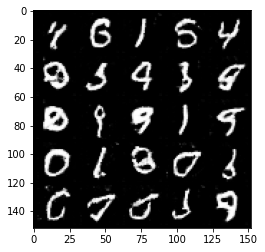

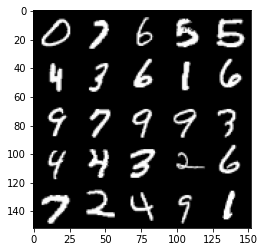

Step 15500: Generator loss: 0.7134545115828518, discriminator loss: 0.6940212130546565


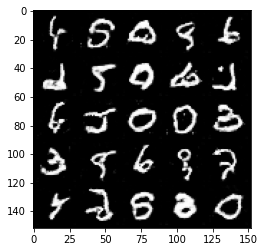

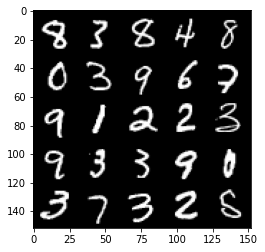

Step 16000: Generator loss: 0.7101833951473235, discriminator loss: 0.6941741648912427


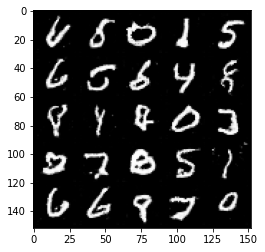

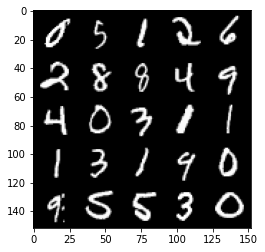

Step 16500: Generator loss: 0.7092292346358293, discriminator loss: 0.6951367152929308


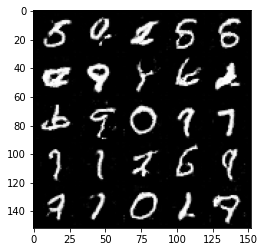

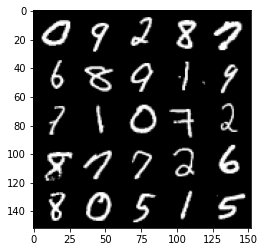

Step 17000: Generator loss: 0.7061288594007493, discriminator loss: 0.6948829474449163


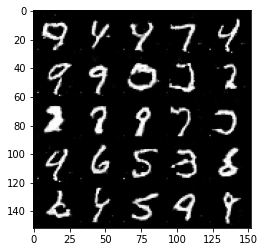

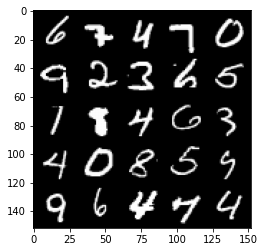

Step 17500: Generator loss: 0.7050395188331606, discriminator loss: 0.6949984403848647


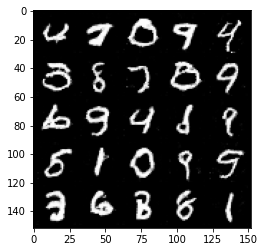

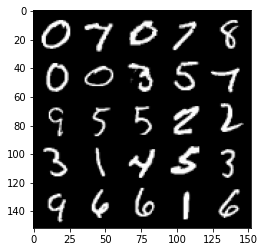

Step 18000: Generator loss: 0.7030026998519904, discriminator loss: 0.6970299460887905


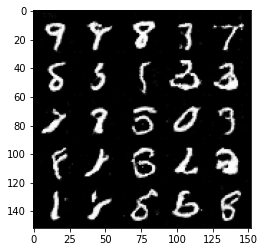

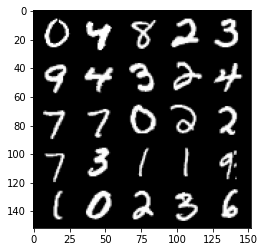

Step 18500: Generator loss: 0.7045797390937801, discriminator loss: 0.6959428139925002


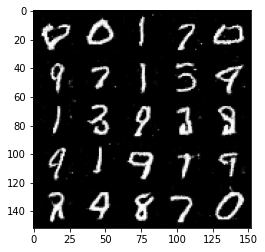

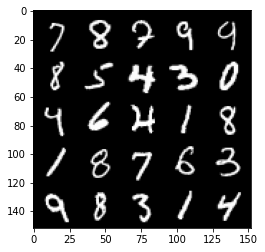

Step 19000: Generator loss: 0.7022330873608587, discriminator loss: 0.6960357395410538


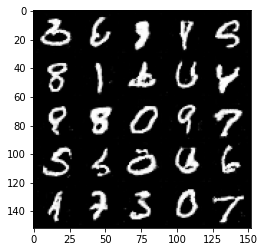

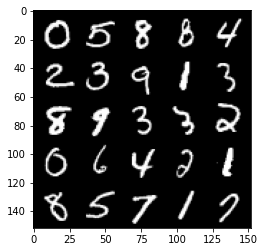

Step 19500: Generator loss: 0.7026124007701875, discriminator loss: 0.6964073120355605


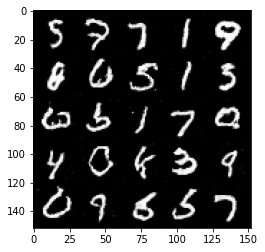

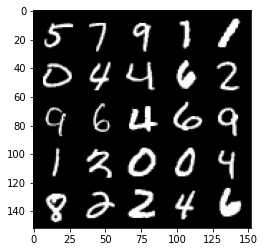

Step 20000: Generator loss: 0.7001869122385984, discriminator loss: 0.6960844213962557


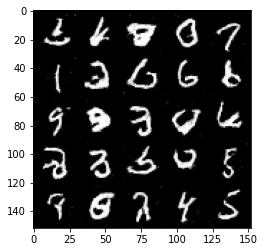

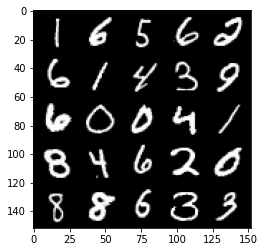

Step 20500: Generator loss: 0.6999571225643159, discriminator loss: 0.6963882558345789


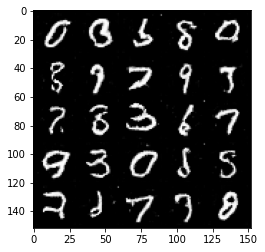

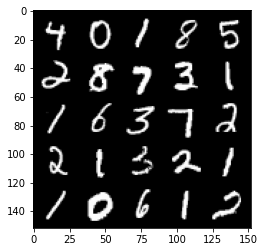

Step 21000: Generator loss: 0.701060386300087, discriminator loss: 0.6962124043703077


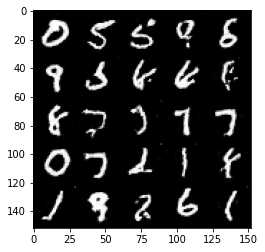

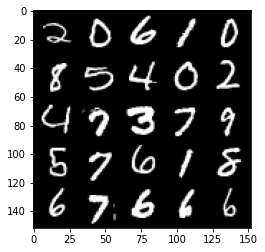

Step 21500: Generator loss: 0.6992401959896092, discriminator loss: 0.6956738493442537


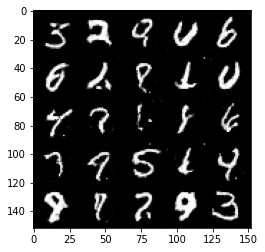

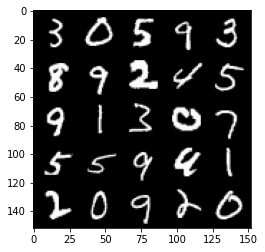

Step 22000: Generator loss: 0.6997761889696125, discriminator loss: 0.6955447376966472


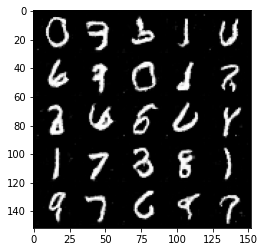

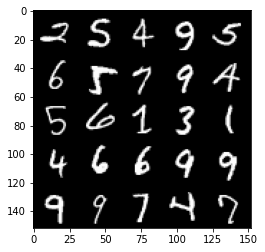

Step 22500: Generator loss: 0.6991297044754031, discriminator loss: 0.6961377466917033


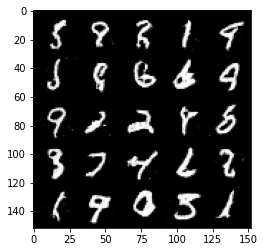

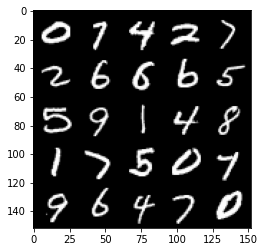

Step 23000: Generator loss: 0.6990028495788568, discriminator loss: 0.6958414591550826


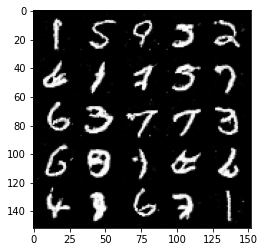

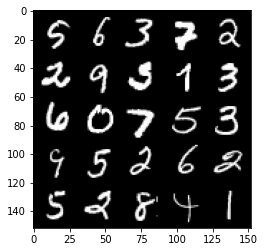

In [7]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
